# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import torch.nn
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Dataset

In [2]:
dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis

In [50]:
# Checking if there is NULL values anywhere in the dataset
print('Null values in Dataset : ',int(np.any(dataset.isna().any())))

# Scaling 'Amount' Feature since its having a different range 
dataset['Amount'] = StandardScaler().fit_transform(dataset['Amount'].values.reshape(-1,1))

# Features
X = dataset.drop(['Time','Class'], axis=1) # Dropping Time since its of no use
# Target Class
y = dataset['Class']

print('Number of Observations in the dataset : ', X.shape[0])
print('Number of Features to be used : ', X.shape[1])
print(f'Fraud cases : {sum(y)}         {np.round(sum(y)/X.shape[0]*100, 3)}%')

Null values in Dataset :  0
Number of Observations in the dataset :  284807
Number of Features to be used :  29
Fraud cases : 492         0.173%


# Oversampling minority class using SMOTE

In [4]:
over = SMOTE(sampling_strategy=0.1)
X_res, y_res = over.fit_resample(X, y)
print('Oversampled dataset shape %s' % Counter(y_res))

Oversampled dataset shape Counter({0: 284315, 1: 28431})


# Undersampling Majority class using RandomUnderSampler

In [5]:
under = RandomUnderSampler(sampling_strategy=0.5)
X_res, y_res = under.fit_resample(X_res, y_res)
print('Undersampled dataset shape %s' % Counter(y_res))

Undersampled dataset shape Counter({0: 56862, 1: 28431})


# Train Test Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25)
print('-------------- Training Data --------------')
print(f'X train : {X_train.shape}       y train : {len(y_train)}')
print(f'Fraud cases : {sum(y_train)}         {np.round(sum(y_train)/X_train.shape[0]*100, 3)}%')
print('---------------- Test Data ----------------')
print(f'X test : {X_test.shape}        y test : {len(y_test)}')
print(f'Fraud cases : {sum(y_test)}          {np.round(sum(y_test)/X_test.shape[0]*100, 3)}%')
ROC = {}

-------------- Training Data --------------
X train : (63969, 29)       y train : 63969
Fraud cases : 21368         33.404%
---------------- Test Data ----------------
X test : (21324, 29)        y test : 21324
Fraud cases : 7063          33.122%


# Random Forest

In [8]:
model = RandomForestClassifier(max_depth=2, bootstrap=True, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

ROC = {}
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = round(roc_auc_score(y_test, y_prob), 4)
ROC['Random_Forest'] = [fpr, tpr, auc]

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     14179
           1       1.00      0.84      0.91      7145

    accuracy                           0.95     21324
   macro avg       0.96      0.92      0.94     21324
weighted avg       0.95      0.95      0.95     21324



# XGBoost

In [74]:
model = XGBClassifier(max_depth=1,random_state=66)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = round(roc_auc_score(y_test, y_prob), 4)
ROC['XGBoost'] = [fpr, tpr, auc]


              precision    recall  f1-score   support

           0       0.96      0.99      0.98     14261
           1       0.98      0.92      0.95      7063

    accuracy                           0.97     21324
   macro avg       0.97      0.95      0.96     21324
weighted avg       0.97      0.97      0.97     21324



# Decision Tree

In [10]:
model = DecisionTreeClassifier(random_state=40)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = round(roc_auc_score(y_test, y_prob), 4)
ROC['Decision_Tree'] = [fpr, tpr, auc]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14179
           1       0.98      0.99      0.99      7145

    accuracy                           0.99     21324
   macro avg       0.99      0.99      0.99     21324
weighted avg       0.99      0.99      0.99     21324



# Logistic Regression

In [40]:
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = round(roc_auc_score(y_test, y_prob), 4)
ROC['Logistic_Regression'] = [fpr, tpr, auc]

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14179
           1       0.98      0.89      0.93      7145

    accuracy                           0.96     21324
   macro avg       0.96      0.94      0.95     21324
weighted avg       0.96      0.96      0.96     21324



0.8741333486726068

# K Nearest Neighbours

In [12]:
model = KNN(n_neighbors=5, random_state=40)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = round(roc_auc_score(y_test, y_prob), 4)
ROC['KNN'] = [fpr, tpr, auc]

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14179
           1       0.99      1.00      0.99      7145

    accuracy                           1.00     21324
   macro avg       0.99      1.00      0.99     21324
weighted avg       1.00      1.00      1.00     21324



# Support Vector Machine

In [47]:
model = SVC(random_state=23)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
auc = round((1/2 - (fpr/2) + (tpr/2)), 4) # estimate of auc
ROC['SVM'] = [[fpr,1], [tpr,1], auc]
auc

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14179
           1       0.99      0.91      0.95      7145

    accuracy                           0.97     21324
   macro avg       0.97      0.95      0.96     21324
weighted avg       0.97      0.97      0.97     21324



0.954

# K means Clustering

In [43]:
model = KMeans(n_clusters=2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tpr = tp/(tp+fn)
fpr = fp/(tn+fp)
auc = round((1/2 - (fpr/2) + (tpr/2)), 4) # estimate of auc
ROC['KMeans'] = [[fpr,1-fpr], [tpr,1-tpr], auc]

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     14179
           1       1.00      0.33      0.50      7145

    accuracy                           0.78     21324
   macro avg       0.87      0.67      0.68     21324
weighted avg       0.83      0.78      0.74     21324



# Neural Network - MLP Classifier

In [79]:
# --------------------------- Default Parameters -----------------------------
# SGD optimizer, uses CrossEntropyLoss, batch_size=200, lr=0.001, max_iter=200, 
# shuffle=true, l2 alpha=0.0001, hidden layer=100, activation=ReLu
model = MLPClassifier(random_state=46)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = round(roc_auc_score(y_test, y_prob), 4)
ROC['MLP'] = [fpr, tpr, auc]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14261
           1       1.00      1.00      1.00      7063

    accuracy                           1.00     21324
   macro avg       1.00      1.00      1.00     21324
weighted avg       1.00      1.00      1.00     21324



# ROC - AUC - Curve

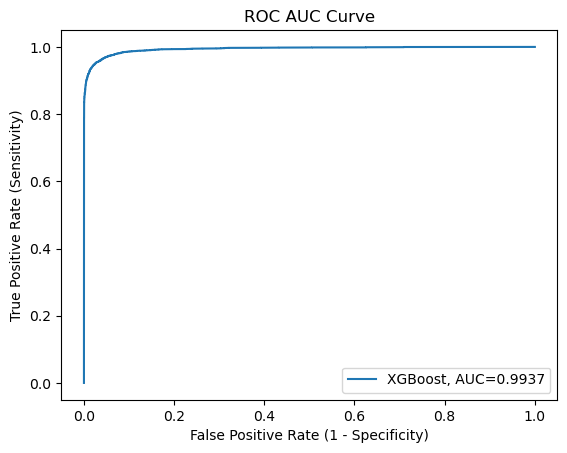

In [75]:
# ----------------------------------------------- ROC AUC curve --------------------------------------------------
# TPR = TP/(TP+FN) => Proportion of observations correctly predicted to be +ve out of all +ve observations(TP+FN)
# FPR = FP/(TN+FP) => Proportion of observations incorrectly predicted to be +ve out of all -ve observations(TN+FP)
# Sensitivity --> TPR
# Specificity --> 1 - FPR
for model in ROC:

    # ------------ FPR --------- TPR ----------------------------------- AUC ----
    plt.plot(ROC[model][0],ROC[model][1], label=model+", AUC="+str(ROC[model][2]))
    
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.title("ROC AUC Curve")
plt.legend()
plt.show()